In [1]:
import os

exp_dates = [f for f in os.listdir("experiments-results/experiments")]
exp_dates.sort()

for d in exp_dates[::-1]:
    if os.listdir(f"experiments-results/experiments/{d}")[0] == "bencher":
        exp_date = d
        break


exp_dir = f"experiments-results/experiments/{d}/bencher"

config_dirs = [f for f in os.listdir(exp_dir) if f.startswith("configuration")]
config_dirs.sort()

print(exp_dir)

experiments-results/experiments/2021-06-21T10:23:08.194677739+00:00/bencher


In [2]:
# latency cdfs data

import json
from collections import defaultdict
from datetime import datetime, timezone, timedelta

latencies = defaultdict(list) # mapping from config json to latency list

for config in config_dirs:
    print("processing", config)
    c = json.dumps(json.loads("".join(open(f"{exp_dir}/{config}/configuration.json").readlines()))["Bencher"])
    
    for repeat in os.listdir(f"{exp_dir}/{config}"):
        if repeat.startswith("repeat"): 
            # read logs of docker-bench
            with open(f"{exp_dir}/{config}/{repeat}/logs/docker-bench.log", "r") as log:
                for line in log.readlines():
                    j = line.split()[1]
                    
                    output = json.loads(j)
                    
                    start_secs = output["start"]["secs_since_epoch"]
                    start_nanos = output["start"]["nanos_since_epoch"]
                    start = datetime(1970, 1, 1, tzinfo=timezone.utc) + timedelta(seconds=start_secs,microseconds=start_nanos/1000)

                    end_secs = output["end"]["secs_since_epoch"]
                    end_nanos = output["end"]["nanos_since_epoch"]
                    end = datetime(1970, 1, 1, tzinfo=timezone.utc) + timedelta(seconds=end_secs,microseconds=end_nanos/1000)
                    
                    latency = end - start
                    latencies[c].append((latency / timedelta(microseconds=1))/1000.)

processing configuration-1
processing configuration-2
processing configuration-3


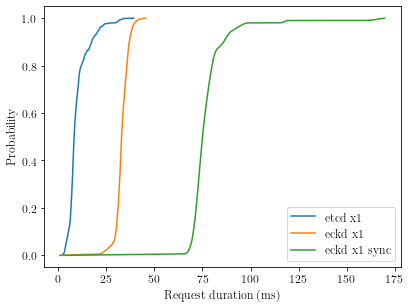

In [6]:
# latency cdfs plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

f = plt.figure()
f.set_figwidth(6.4 * 1)
f.set_figheight(4.8 * 1)
    
for (k, v) in latencies.items():
    config = json.loads(k)
    cluster_size = config["cluster_size"]
    if cluster_size == 1:
        image = "etcd" if config["image_name"] == "quay.io/coreos/etcd" else "eckd"
        sync = " sync" if "--sync" in config["extra_args"] else ""

        v.sort()
        size = len(v)
        ys = np.array(range(size))/ float(size)

        plt.plot(v, ys, label=f"{image} x{cluster_size}{sync}")
    
plt.xlabel("Request duration (ms)")
plt.ylabel("Probability")
plt.legend()

plt.savefig(f"{exp_dir}/plots/latency-cdf.pdf")